<a href="https://colab.research.google.com/github/printAsmamaw/BreastCancer_Detection/blob/main/5flowerClassificationCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***SetUp***

Import Tensorflow and other necessary liberaries:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Download and explore the dataset

*This vidoes i use a dataset of about 3,700 photos of flower.The dataset contains five sub-directories,one per class:*

In [ ]:
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/

In [ ]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')



228813984/228813984 [==============================] - 1s 0us/step


In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


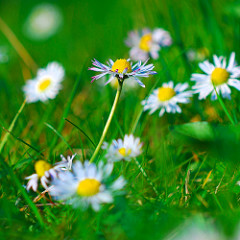

In [ ]:
roses = list(data_dir.glob('daisy/*'))
PIL.Image.open(str(roses[3]))

**Load data using a keras utility**

In [ ]:
batch_size=32
img_height=180
img_width=180


Use 80% of the images for trainging and 20% for validation

#1,,,,,,,,, labels are generated from the directory structure

image_dataset_from_directory function

tf.keras.preprocessing.image_dataset_from_directory:

This function is used to create a dataset from a directory containing subdirectories of images. It automatically labels the data based on the subdirectory names. It returns a tf.data.Dataset object.

dataset/

    ├── cats/

    │   ├── cat1.jpg

    │   ├── cat2.jpg

    │   └── ...

    └── dogs/

        ├── dog1.jpg

        ├── dog2.jpg

        └── ...


In [ ]:
train_ds=tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds=tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
class_names=train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


***Visualize the data***

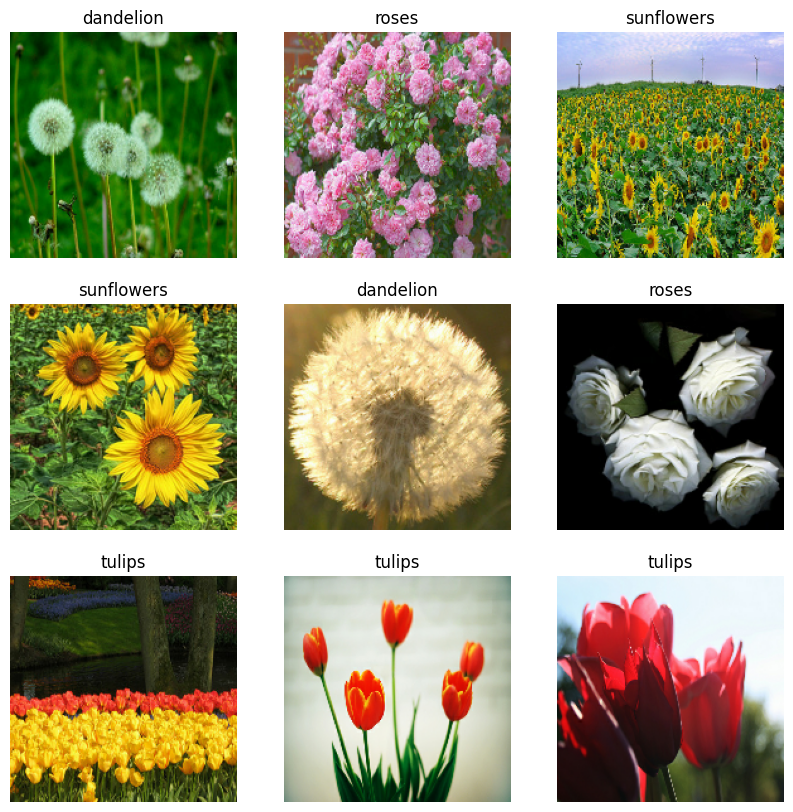

In [ ]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

***Configure the dataset for performance***

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

***Standardize the data***

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network:In general you should seek to make your input valus small.

Here ,you will standardize values to be in the [0, 1] range by using
tf.keras.layers.Rescaling:

In [ ]:
normalization_layer=layers.Rescaling(1./255)


In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


**Visualize training results**

Create plots of the loss and accuracy on the training and validation sets:

**Data augmentation**

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

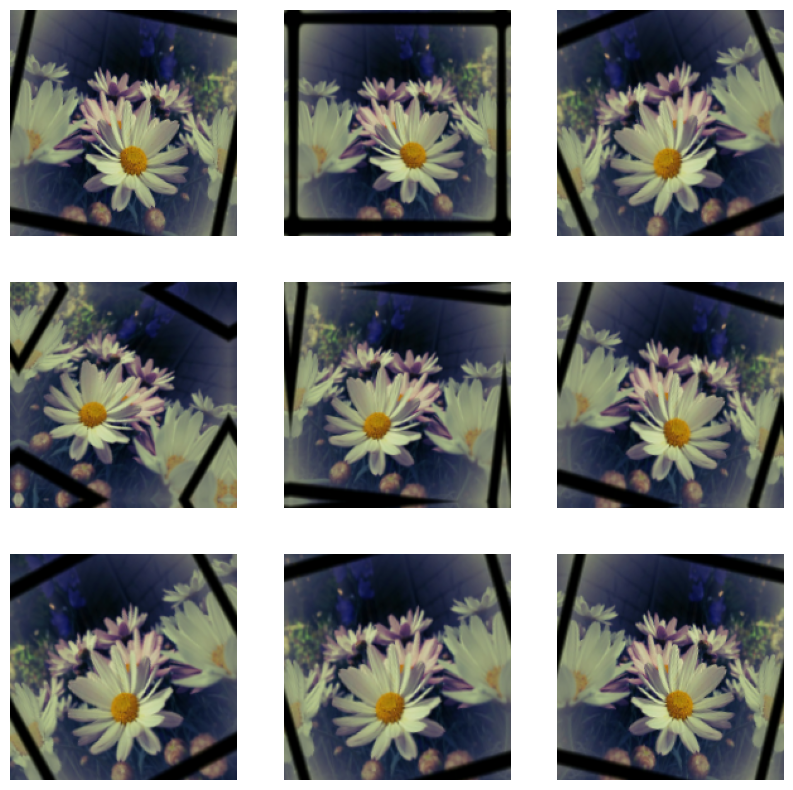

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

**Create the model**

In [ ]:
num_classes=5

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

**Compile the model**

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Model Summery**

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

**Train the model**

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 119s 1s/step - loss: 1.4041 - accuracy: 0.3784 - val_loss: 1.2009 - val_accuracy: 0.4932
Epoch 2/15
92/92 [==============================] - 109s 1s/step - loss: 1.0970 - accuracy: 0.5542 - val_loss: 1.0296 - val_accuracy: 0.5886
Epoch 3/15
92/92 [==============================] - 104s 1s/step - loss: 0.9908 - accuracy: 0.6107 - val_loss: 1.1865 - val_accuracy: 0.5409
Epoch 4/15
92/92 [==============================] - 111s 1s/step - loss: 0.9264 - accuracy: 0.6512 - val_loss: 0.9746 - val_accuracy: 0.6076
Epoch 5/15
92/92 [==============================] - 112s 1s/step - loss: 0.8558 - accuracy: 0.6778 - val_loss: 0.8481 - val_accuracy: 0.6730
Epoch 6/15
92/92 [==============================] - 110s 1s/step - loss: 0.8015 - accuracy: 0.6901 - val_loss: 0.8076 - val_accuracy: 0.6703
Epoch 7/15
92/92 [==============================] - 108s 1s/step - loss: 0.7552 - accuracy: 0.7129 - val_loss: 0.7557 - val_accuracy: 0.7044
Epoch 8/15
92

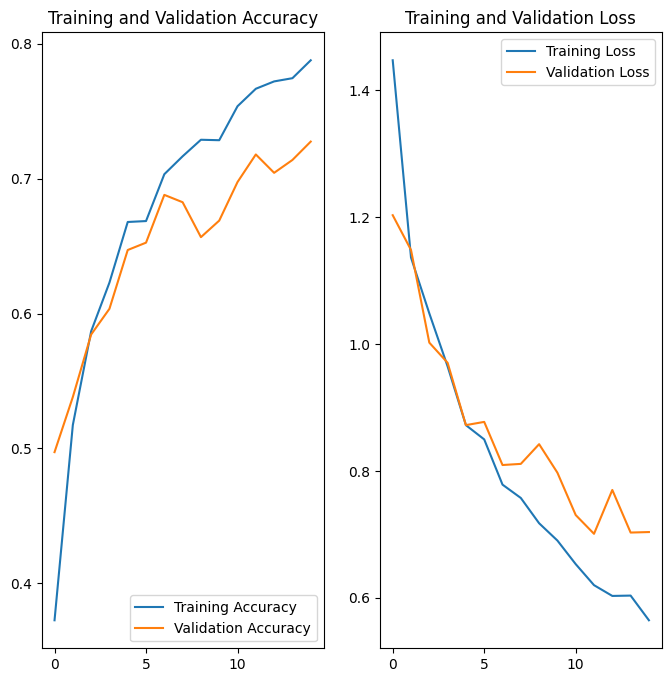

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Predict on new data**

**load_img function**

tf.keras.utils.load_img:

This function is used to load a single image from a file. It returns a PIL (Python Imaging Library) image

img_to_array function

tf.keras.utils.img_to_array(img, data_format=None, dtype=None)

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
#[0.8,0.4,0.45,0.23,0.2]
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 221ms/step
This image most likely belongs to sunflowers with a 99.96 percent confidence.
